## Individual Subcomponent Test for ML - Week 7

#### Dataset : https://archive.ics.uci.edu/ml/datasets/Smartphone-Based+Recognition+of+Human+Activities+and+Postural+Transitions

`30` subjects & `12` activities.
3-axial linear acceleration and 3-axial angular velocity at a constant rate of `50Hz` using the embedded accelerometer and gyroscope of the device. 

The obtained dataset was randomly partitioned into two sets, where `70%` of the volunteers was selected for generating the `training data` and `30%` the `test data`.

- The sensor signals (accelerometer and gyroscope) were pre-processed by applying noise filters and then sampled in fixed-width `sliding windows of 2.56 sec` and `50% overlap (128 readings/window)`. 
- The sensor acceleration signal, which has gravitational and body motion components, was separated using a Butterworth low-pass filter into body acceleration and gravity. 
- The gravitational force is assumed to have only low frequency components, therefore a filter with 0.3 Hz cutoff frequency was used. 
- From `each window`, a vector of `561 features` was obtained by calculating variables from the time and frequency domain. 

#### Libraries used : 
- scikit-learn
- pytorch

#### References : 
- https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/
- https://chrisalbon.com/code/machine_learning/trees_and_forests/feature_selection_using_random_forest/
- https://deeplizard.com/learn/video/0LhiS6yu2qQ
- https://towardsdatascience.com/pytorch-tabular-multiclass-classification-9f8211a123ab
- https://towardsdatascience.com/multiclass-classification-using-k-nearest-neighbours-ca5281a9ef76
- https://sebastianraschka.com/blog/2016/model-evaluation-selection-part3.html





In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split,SubsetRandomSampler, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold



from statistics import mean, stdev
import random
import csv
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sn
plt.style.use('ggplot')
sn.set_style("whitegrid")
%matplotlib inline

In [2]:
# Read in activity num & labels as a df
activity_label_df = pd.read_csv('../data2/HAPT Data Set/activity_labels.txt',delim_whitespace=True, header=None)
activity_num = np.arange(0,12)
labels = np.array(activity_label_df[1])
print(f"labels : {labels}")
print(f"activity_num : {activity_num}")

# Read in features extracted as a df 
features_df = pd.read_csv('../data2/HAPT Data Set/features.txt',delim_whitespace=True, header=None)
features = np.array(features_df[0])
# print(f"features : {features}")
print(f"Total number of training feature columns : {features.size}")

# create map of activity num to activity name 
map_num_to_activity = {}
for i,num in enumerate(activity_num):
    map_num_to_activity[num] = labels[i]
map_num_to_activity

labels : ['WALKING' 'WALKING_UPSTAIRS' 'WALKING_DOWNSTAIRS' 'SITTING' 'STANDING'
 'LAYING' 'STAND_TO_SIT' 'SIT_TO_STAND' 'SIT_TO_LIE' 'LIE_TO_SIT'
 'STAND_TO_LIE' 'LIE_TO_STAND']
activity_num : [ 0  1  2  3  4  5  6  7  8  9 10 11]
Total number of training feature columns : 561


{0: 'WALKING',
 1: 'WALKING_UPSTAIRS',
 2: 'WALKING_DOWNSTAIRS',
 3: 'SITTING',
 4: 'STANDING',
 5: 'LAYING',
 6: 'STAND_TO_SIT',
 7: 'SIT_TO_STAND',
 8: 'SIT_TO_LIE',
 9: 'LIE_TO_SIT',
 10: 'STAND_TO_LIE',
 11: 'LIE_TO_STAND'}

### Load Training Set 

In [3]:
X = pd.read_csv('../data2/HAPT Data Set/Train/X_train.txt',delim_whitespace=True, header=None)
print(f"X shape when loaded from txt: {X.shape}")
X.columns = features
X['Subject'] = pd.read_csv('../data2/HAPT Data Set/Train/subject_id_train.txt', header=None, squeeze=True)
print(f"X shape after including subject number: {X.shape}")

y = pd.read_csv('../data2/HAPT Data Set/Train/y_train.txt', names=['Activity'], squeeze=True)
y = y-1
X['Activity'] = y
X['ActivityName'] = X["Activity"].map(map_num_to_activity)

print(f"X shape after including activity and activity name: {X.shape}")
print('No of duplicates in X: {}'.format(sum(X.duplicated())))
print('We have {} NaN/Null values in X'.format(X.isnull().values.sum()))

X_vals = X.drop(["Subject", "Activity", "ActivityName"], axis = 1).values
X.sample()

X shape when loaded from txt: (7767, 561)
X shape after including subject number: (7767, 562)
X shape after including activity and activity name: (7767, 564)
No of duplicates in X: 0
We have 0 NaN/Null values in X


,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,Subject,Activity,ActivityName
7161,0.037915,0.070938,-0.011379,-0.105976,-0.331226,-0.136394,-0.205556,-0.373174,-0.279088,0.341157,...,0.149011,-0.76186,-0.804907,0.625453,-0.773254,0.247228,-0.026069,29,1,WALKING_UPSTAIRS


### Load Test Set 

In [4]:
# get the data from txt files to pandas dataffame
x_t = pd.read_csv('../data2/HAPT Data Set/Test/X_test.txt', delim_whitespace=True, header=None)
print(f"x_t shape when loaded from txt: {x_t.shape}")
x_t.columns = features

# add subject column to the dataframe
x_t['Subject'] = pd.read_csv('../data2/HAPT Data Set/Test/subject_id_test.txt', header=None, squeeze=True)
print(f"x_t shape after including subject number: {x_t.shape}")

# get y labels from the txt file
y_t = pd.read_csv('../data2/HAPT Data Set/Test/y_test.txt', names=['Activity'], squeeze=True)
y_t = y_t -1
x_t['Activity'] = y_t
x_t['ActivityName'] = x_t["Activity"].map(map_num_to_activity)

print(f"x_t shape after including activity and activity name: {x_t.shape}")
print('No of duplicates in x_t: {}'.format(sum(x_t.duplicated())))
print('We have {} NaN/Null values in x_t'.format(x_t.isnull().values.sum()))

x_tvals = x_t.drop(["Subject", "Activity", "ActivityName"], axis = 1).values
x_t.sample()

x_t shape when loaded from txt: (3162, 561)
x_t shape after including subject number: (3162, 562)
x_t shape after including activity and activity name: (3162, 564)
No of duplicates in x_t: 0
We have 0 NaN/Null values in x_t


,tBodyAcc-Mean-1,tBodyAcc-Mean-2,tBodyAcc-Mean-3,tBodyAcc-STD-1,tBodyAcc-STD-2,tBodyAcc-STD-3,tBodyAcc-Mad-1,tBodyAcc-Mad-2,tBodyAcc-Mad-3,tBodyAcc-Max-1,...,tBodyAcc-AngleWRTGravity-1,tBodyAccJerk-AngleWRTGravity-1,tBodyGyro-AngleWRTGravity-1,tBodyGyroJerk-AngleWRTGravity-1,tXAxisAcc-AngleWRTGravity-1,tYAxisAcc-AngleWRTGravity-1,tZAxisAcc-AngleWRTGravity-1,Subject,Activity,ActivityName
816,0.039884,-0.003784,-0.004452,-0.983228,-0.954961,-0.932004,-0.98644,-0.957683,-0.940761,-0.784937,...,0.071125,0.37018,0.150019,0.873106,-0.850498,0.084026,0.132377,9,4,STANDING


### Data Visualisation

In [5]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.grid(False)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


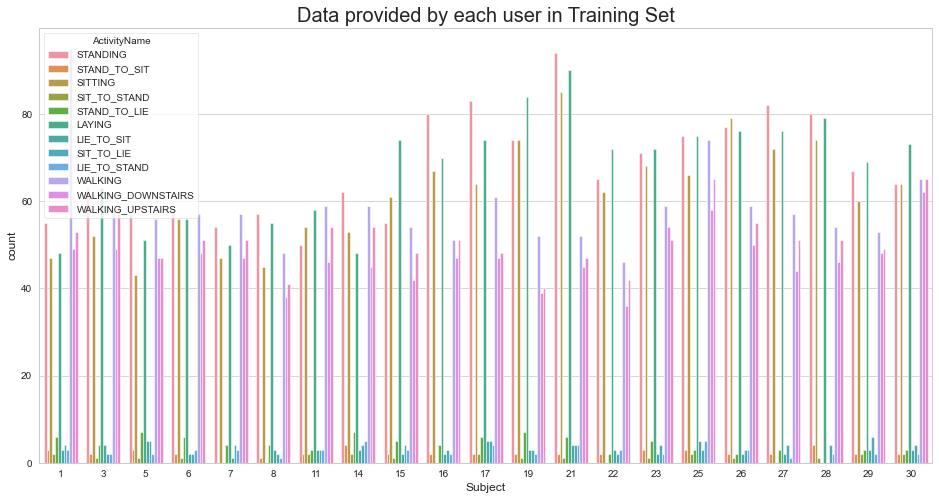

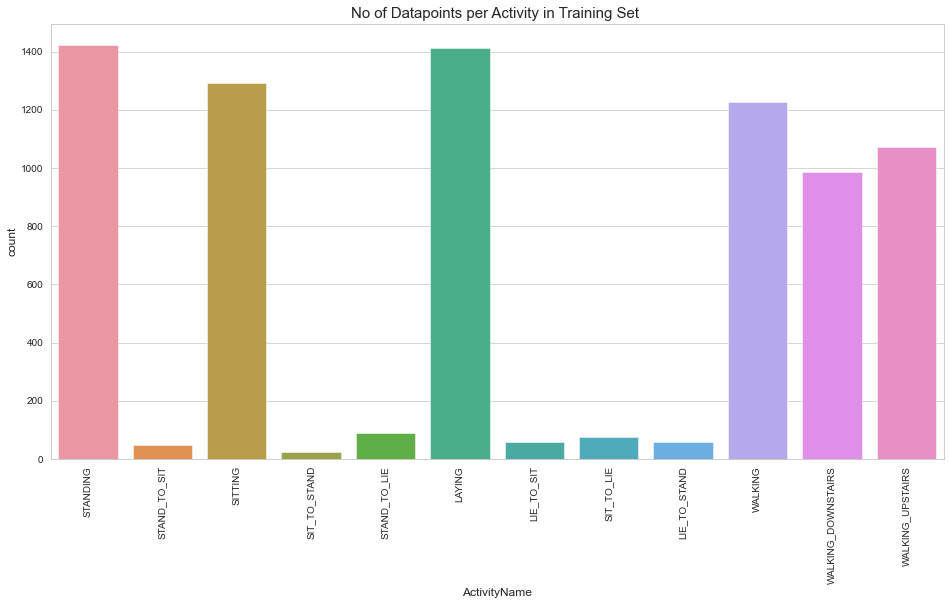

In [6]:
plt.figure(figsize = (16,8))
plt.title("Data provided by each user in Training Set", fontsize = 20)
sn.countplot(x ="Subject", hue ="ActivityName", data =X)
plt.show()

plt.figure(figsize = (16,8))
plt.title('No of Datapoints per Activity in Training Set ', fontsize=15)
sn.countplot(x = X["ActivityName"])
plt.xticks(rotation=90)
plt.show()

### Feature Selection
Feature selection using Random forest is parked under the category of Embedded methods. 
Benefits of embedded methods:
- Highly accurate.
- Generalize better.
- Interpretable

We select features using the training set. 

In [7]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_vals, y)
# for feature in zip(features, rf.feature_importances_):
#     print(feature)
sfm = SelectFromModel(rf)
sfm.fit(X_vals, y)

# for feature_list_index in sfm.get_support(indices=True):
#     print(features[feature_list_index])
X_important_train = sfm.transform(X_vals)
X_important_test = sfm.transform(x_tvals)
print(f"Number of selected features : {len(sfm.get_support(indices=True))}")

Number of selected features : 136


In [8]:
print(f"Number of columns in transformed training set: {len(X_important_train[0])}")

Number of columns in transformed training set: 136


### Stratified K fold Cross Validation 

- K fold Cross Validation is a technique used to evaluate the performance of a machine learning or deep learning model in a robust way.
- It splits the dataset into k parts/folds of approximately equal size. Each fold is chosen in turn for testing and the remaining parts for training.
- This process is repeated k times and then the performance is measured as the mean across all the test sets.

Stratified K fold CV uses stratified sampling. In our case, we use the "test" set in each fold as the validation set. This way, we can tune the hyperparameters to yield better classification results. Upon training, we run the model on unseen test set data which was prepared earlier. 

In [9]:
def traditional_models_fold_trainer(model, x,y, name):
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
    scores = []
    for train_index, test_index in skf.split(x, y):
        x_train_fold, x_test_fold = x[train_index], x[test_index]
        y_train_fold, y_test_fold = y[train_index], y[test_index]
        model.fit(x_train_fold, y_train_fold)
        scores.append(model.score(x_test_fold, y_test_fold))
    print(f"-------------------------{name}--------------------------------")
    print()
    print('List of possible accuracy:', scores)
    print(f"\nMaximum Accuracy That can be obtained from {name} is:", max(scores)*100, '%')
    print('\nMinimum Accuracy:',min(scores)*100, '%')
    print('\nOverall Accuracy:',mean(scores)*100, '%')
    print('\nStandard Deviation is:', stdev(scores))
    print(f"---------------------------------------------------------------")
    print()

### SVM Classifier 

In [10]:
linear = svm.SVC(kernel='linear', C=1, decision_function_shape='ovo')
rbf = svm.SVC(kernel='rbf', gamma=1, C=1, decision_function_shape='ovo')
poly = svm.SVC(kernel='poly', degree=3, C=1, decision_function_shape='ovo')
sig = svm.SVC(kernel='sigmoid', C=1, decision_function_shape='ovo')
traditional_models_fold_trainer(linear,X_important_train, y, "linearSVM")
traditional_models_fold_trainer(rbf,X_important_train, y, "RBF")
traditional_models_fold_trainer(poly,X_important_train, y, "Poly")
traditional_models_fold_trainer(sig,X_important_train, y, "Sig")

-------------------------linearSVM--------------------------------

List of possible accuracy: [0.9613899613899614, 0.9652509652509652, 0.963963963963964, 0.972972972972973, 0.954954954954955, 0.9588159588159588, 0.963963963963964, 0.9690721649484536, 0.9523195876288659, 0.9561855670103093]

Maximum Accuracy That can be obtained from linearSVM is: 97.2972972972973 %

Minimum Accuracy: 95.23195876288659 %

Overall Accuracy: 96.1889006090037 %

Standard Deviation is: 0.006465656966969198
---------------------------------------------------------------

-------------------------RBF--------------------------------

List of possible accuracy: [0.918918918918919, 0.9266409266409267, 0.9253539253539254, 0.9330759330759331, 0.9163449163449163, 0.9163449163449163, 0.915057915057915, 0.913659793814433, 0.9188144329896907, 0.9201030927835051]

Maximum Accuracy That can be obtained from RBF is: 93.30759330759331 %

Minimum Accuracy: 91.3659793814433 %

Overall Accuracy: 92.0431477132508 %

Standard

### Testing using the test set

In [11]:
linear_pred = linear.predict(X_important_test)
poly_pred = poly.predict(X_important_test)
rbf_pred = rbf.predict(X_important_test)
sig_pred = sig.predict(X_important_test)

In [12]:
accuracy_lin = linear.score(X_important_test, y_t)
accuracy_poly = poly.score(X_important_test, y_t)
accuracy_rbf = rbf.score(X_important_test, y_t)
accuracy_sig = sig.score(X_important_test, y_t)
print("Accuracy Linear Kernel:" , accuracy_lin)
print("Accuracy Polynomial Kernel:" , accuracy_poly)
print("Accuracy Radial Basis Kernel:" , accuracy_rbf)
print("Accuracy Sigmoid Kernel:" , accuracy_sig)

Accuracy Linear Kernel: 0.91808981657179
Accuracy Polynomial Kernel: 0.9174573055028463
Accuracy Radial Basis Kernel: 0.8102466793168881
Accuracy Sigmoid Kernel: 0.685325743200506


#### Evaluation of Linear Kernel

In [13]:
print("Linear Kernel Confusion Matrix:")
print("\n")
print(confusion_matrix(y_t, linear_pred))
print("\n")
print("Linear Kernel Classification Report:",)
print("\n")
print (classification_report(y_t, linear_pred))
print("\n")
print("Linear Kernel Accuracy :", accuracy_score(y_t,linear_pred))
print("\n")

Linear Kernel Confusion Matrix:


[[495   1   0   0   0   0   0   0   0   0   0   0]
 [ 39 429   3   0   0   0   0   0   0   0   0   0]
 [  9  24 387   0   0   0   0   0   0   0   0   0]
 [  0   1   0 422  83   0   1   0   0   0   1   0]
 [  0   0   0  38 518   0   0   0   0   0   0   0]
 [  0   0   0   0   0 544   0   0   0   0   1   0]
 [  1   0   0   2   1   0  17   1   1   0   0   0]
 [  0   0   0   0   0   0   0  10   0   0   0   0]
 [  0   0   0   0   0   0   0   0  26   0   6   0]
 [  0   0   0   0   0   0   0   0   0  16   1   8]
 [  2   1   0   2   0   1   2   0  14   1  26   0]
 [  0   0   0   0   0   0   1   0   0  12   1  13]]


Linear Kernel Classification Report:


              precision    recall  f1-score   support

           0       0.91      1.00      0.95       496
           1       0.94      0.91      0.93       471
           2       0.99      0.92      0.96       420
           3       0.91      0.83      0.87       508
           4       0.86      0.93      0.

#### Evaluation of Polynomial Kernel

In [14]:
print("Polynomial Kernel Confusion Matrix:")
print("\n")
print(confusion_matrix(y_t, poly_pred))
print("\n")
print("Polynomial Kernel Classification Report:",)
print("\n")
print (classification_report(y_t, poly_pred))
print("\n")
print("Polynomial Kernel Accuracy :", accuracy_score(y_t,poly_pred))
print("\n")

Polynomial Kernel Confusion Matrix:


[[493   0   3   0   0   0   0   0   0   0   0   0]
 [ 38 427   6   0   0   0   0   0   0   0   0   0]
 [ 10  26 384   0   0   0   0   0   0   0   0   0]
 [  0   1   0 425  78   0   2   0   0   0   2   0]
 [  0   0   0  34 522   0   0   0   0   0   0   0]
 [  0   0   0   0   0 545   0   0   0   0   0   0]
 [  0   3   0   2   1   0  14   1   1   0   1   0]
 [  0   0   0   0   0   0   2   8   0   0   0   0]
 [  0   0   0   0   0   0   0   0  29   0   3   0]
 [  0   0   0   0   0   0   0   0   1  16   0   8]
 [  2   2   0   2   0   0   2   0  14   2  25   0]
 [  0   0   0   0   0   0   0   0   0  10   4  13]]


Polynomial Kernel Classification Report:


              precision    recall  f1-score   support

           0       0.91      0.99      0.95       496
           1       0.93      0.91      0.92       471
           2       0.98      0.91      0.94       420
           3       0.92      0.84      0.88       508
           4       0.87      0.94

### KNN classifier 

KNN believes that similar things are in close proximity of each other. Hence, if a datapoint is near to another datapoint, KNN assumes that they both belong to the same class.

In [15]:
knn_clf=KNeighborsClassifier()
traditional_models_fold_trainer(knn_clf,X_important_train, y, "KNN")

-------------------------KNN--------------------------------

List of possible accuracy: [0.9446589446589446, 0.9613899613899614, 0.9536679536679536, 0.9601029601029601, 0.9330759330759331, 0.9433719433719434, 0.9485199485199485, 0.9587628865979382, 0.9458762886597938, 0.9523195876288659]

Maximum Accuracy That can be obtained from KNN is: 96.13899613899613 %

Minimum Accuracy: 93.30759330759331 %

Overall Accuracy: 95.01746407674243 %

Standard Deviation is: 0.00885184335735973
---------------------------------------------------------------



#### Evaluation of KNN

In [16]:
#These are the predicted output values
ypred=knn_clf.predict(X_important_test) 
print("KNN Confusion Matrix:")
print("\n")
print(confusion_matrix(y_t, ypred))
print("\n")
print("KNN Classification Report:",)
print("\n")
print (classification_report(y_t, ypred))
print("\n")
print("KNN Accuracy:", accuracy_score(y_t,ypred))
print("\n")

KNN Confusion Matrix:


[[474   9  13   0   0   0   0   0   0   0   0   0]
 [ 45 417   9   0   0   0   0   0   0   0   0   0]
 [ 22  58 340   0   0   0   0   0   0   0   0   0]
 [  0   3   0 392 113   0   0   0   0   0   0   0]
 [  1   0   0  39 516   0   0   0   0   0   0   0]
 [  0   0   0   0   0 543   0   0   0   2   0   0]
 [  1   3   0   2   0   0  16   0   1   0   0   0]
 [  0   1   0   0   0   0   2   7   0   0   0   0]
 [  0   0   0   0   0   0   0   0  29   0   3   0]
 [  0   0   0   0   0   0   0   0   1  17   0   7]
 [  3   5   0   2   0   2   1   0  18   0  18   0]
 [  1   0   0   0   0   0   0   0   1  10   1  14]]


KNN Classification Report:


              precision    recall  f1-score   support

           0       0.87      0.96      0.91       496
           1       0.84      0.89      0.86       471
           2       0.94      0.81      0.87       420
           3       0.90      0.77      0.83       508
           4       0.82      0.93      0.87       556
       

### Multi Layer Perceptron Model

#### Defining the MLP model

In [17]:
class Model(nn.Module):
    def __init__(self, in_features, h1, h2, out_features=12):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)            # hidden layer
        self.out = nn.Linear(h2, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.out(x)
        return x

#### Model Instantiation

In [18]:
# Instantiate the Model class using parameter defaults:
torch.manual_seed(32)
hidden_layer_1_nodes = 80
hidden_layer_2_nodes = 40
mlp = Model(in_features=len(X_important_train[0]), h1=hidden_layer_1_nodes, h2=hidden_layer_2_nodes)
X_train = torch.FloatTensor(X_important_train)
X_test = torch.FloatTensor(X_important_test)
y_train = torch.LongTensor(y)
y_test = torch.LongTensor(y_t)
# trainloader = DataLoader(X_train, batch_size=60, shuffle=True)
# testloader = DataLoader(X_test, batch_size=60, shuffle=False)
# len(X_important_train[0])

#### Stratified K Fold Cross Validation & Model Training 
- We have `7767` rows of training data. Assuming `n` features are selected, we create an array of shape `7767 x n `  
     - i.e. X_important_train
- With SKF CV, each fold separates the `7767` rows of data into `q rows` for training and `r rows` for testing
- x_train_fold is of shape `q x n` and x_test_fold is of shape `r x n`

With each fold, we get a training set and validation set. For each epoch, we train the model in batches and validate in batches as specified by their respective batch sizes.

In [19]:
k = 10       
skfcv = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)
training_loss = {}
train_batch_size = 250
test_batch_size = 60
val_acc = []
# per fold 
for fold, (train_index, test_index) in enumerate(skfcv.split(X_train, y_train)):
    x_train_fold, x_test_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_test_fold = y_train[train_index], y_train[test_index]
    train_combined = TensorDataset(x_train_fold, y_train_fold)
    test_combined = TensorDataset(x_test_fold, y_test_fold)
    trainloader = DataLoader(train_combined, batch_size=train_batch_size, shuffle=True)
    testloader = DataLoader(test_combined, batch_size=test_batch_size, shuffle=False)
    # per epoch
    for i in range(epochs): 
        i+=1
        # per batch 
        losses = [] 
        val_correct_preds = 0
        count = 0 
        for batch_idx, (data, target) in enumerate(trainloader):
            mlp.train()
             
            # training 
            y_pred = mlp.forward(data)
            loss = criterion(y_pred, target)
            losses.append(loss)
            
            # backtracking 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step() 
        
        # validating 
        with torch.no_grad():
            mlp.eval()
            for val_batch_idx, (val_data, val_target) in enumerate(testloader):
                y_out = mlp.forward(val_data)
#                 print(y_out.shape[0])
                for row in range(y_out.shape[0]):
#                     print("predicted:" , y_out[row].argmax())
#                     print("actual: ", val_target[row])
                    if y_out[row].argmax() == val_target[row]:
                        val_correct_preds += 1
                    count += 1

            
    # per fold         
    with torch.no_grad():
        training_loss[fold] = np.array(losses).mean()
        print("-----------------------")
        print(f"fold: {fold} , training_loss: {training_loss[fold]}")
        print(f"fold: {fold}, {val_correct_preds} out of {count} = {100*val_correct_preds/count:.2f}% correct")
        print("-----------------------")
        val_acc.append(100*val_correct_preds/count)
        count = 0

print()
print("Done Training")
print("Max Validation Accuracy: ",  np.array(val_acc).max())

-----------------------
fold: 0 , training_loss: 0.04505455121397972
fold: 0, 746 out of 777 = 96.01% correct
-----------------------
-----------------------
fold: 1 , training_loss: 0.04576775059103966
fold: 1, 754 out of 777 = 97.04% correct
-----------------------
-----------------------
fold: 2 , training_loss: 0.029242822900414467
fold: 2, 760 out of 777 = 97.81% correct
-----------------------
-----------------------
fold: 3 , training_loss: 0.019988233223557472
fold: 3, 769 out of 777 = 98.97% correct
-----------------------
-----------------------
fold: 4 , training_loss: 0.005179093685001135
fold: 4, 767 out of 777 = 98.71% correct
-----------------------
-----------------------
fold: 5 , training_loss: 0.0007793913828209043
fold: 5, 773 out of 777 = 99.49% correct
-----------------------
-----------------------
fold: 6 , training_loss: 0.00013208533346187323
fold: 6, 772 out of 777 = 99.36% correct
-----------------------
-----------------------
fold: 7 , training_loss: 0.000

In [20]:
#         if i%10 == 1:
#             print("epoch: " , i)
#             if i%10 == 1:
#             print(f'batch: {batch_idx:2} epoch: {i:2}  loss: {loss.item():10.8f}')

#             if batch_idx %100 == 1:
#             print("         batch_idx: " ,batch_idx)
#             print(f"predicted : {y_pred}, actual : {target}")

#     print(x_train_fold.shape)
#     train_stacked = torch.from_numpy(np.c_[(x_train_fold.numpy(),y_train_fold.numpy())])
#     test_stacked = torch.from_numpy(np.c_[(x_test_fold.numpy(),y_test_fold.numpy())])
#     print(test_stacked.shape)

#         dataloader_iterator = iter(testloader)
#             try:
#                 valdata, expectedOut = next(dataloader_iterator)
#             except StopIteration:
#                 dataloader_iterator = iter(testloader)
#                 valdata, expectedOut = next(dataloader_iterator)


#  print("out of mlp ", y_out.shape)
#             print("expected out: " , val_target[val_batch_idx])
#             print("predicted output: ", y_out[batch_idx].argmax())
#             print("entire batch target : ", val_target.shape)

#  print("batch idx: ", val_batch_idx)

#### Mean Training Loss per fold 

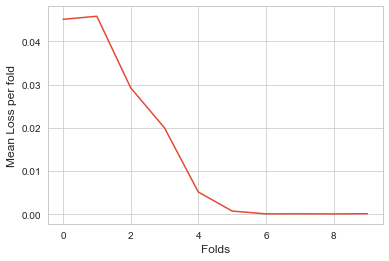

In [21]:
# splits=KFold(n_splits=10,shuffle=True,random_state=42)
# for fold, (train_idx,val_idx) in enumerate(splits.split(np.arange(len(trainloader)))):
with torch.no_grad():
    y_axis  = training_loss.values()
    plt.plot(range(10), y_axis)
    plt.ylabel('Mean Loss per fold')
    plt.xlabel('Folds')  
    

### Evaluation of MLP 

#### Running the model on unseen, test data set

In [22]:
# TO EVALUATE THE ENTIRE TEST SET
with torch.no_grad():
    start_time = time.time()
    y_val = mlp.forward(X_test)
    print("--- %s execution time in seconds ---" % (time.time() - start_time))
    loss = criterion(y_val, y_test)
    print(f'Loss with test set : {loss:.8f}')

--- 0.02405095100402832 execution time in seconds ---
Loss with test set : 1.51632404


In [23]:
with torch.no_grad():
    preds = []
    correct = 0
    for i,data in enumerate(X_test):
        y_val = mlp.forward(data)
#         print(f'{i+1:2}. {str(y_val):38}  {y_test[i]}')
#         print(y_val.argmax().item(),y_test[i], y_val.argmax() )
        preds.append(y_val.argmax().item())
        if y_val.argmax().item() == y_test[i]:
            correct += 1
    print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')
    y_preds = torch.tensor(preds, dtype = torch.int64)
    stacked = torch.stack((y_test,y_preds),dim=1)
#     print(stacked.shape)
#     print(stacked)
    cmt = torch.zeros(12,12, dtype=torch.int64)
    for p in stacked:
        tl, pl = p.tolist()
#         print(tl,pl)
        cmt[tl, pl] = cmt[tl, pl] + 1   
#     print(cmt)


2866 out of 3162 = 90.64% correct


Confusion matrix, without normalization
tensor([[487,   3,   5,   0,   0,   0,   0,   0,   0,   0,   1,   0],
        [ 51, 409,  10,   0,   0,   0,   1,   0,   0,   0,   0,   0],
        [  9,  26, 385,   0,   0,   0,   0,   0,   0,   0,   0,   0],
        [  0,   0,   0, 438,  69,   0,   0,   1,   0,   0,   0,   0],
        [  2,   0,   0,  58, 495,   0,   0,   1,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0, 542,   0,   0,   0,   1,   2,   0],
        [  2,   2,   0,   1,   0,   0,  13,   4,   1,   0,   0,   0],
        [  0,   0,   0,   0,   1,   0,   0,   9,   0,   0,   0,   0],
        [  0,   0,   0,   1,   0,   0,   0,   0,  24,   0,   7,   0],
        [  0,   0,   0,   1,   0,   0,   0,   0,   0,  14,   1,   9],
        [  3,   0,   0,   2,   0,   1,   1,   1,  10,   1,  30,   0],
        [  0,   0,   0,   0,   0,   0,   0,   0,   1,   4,   2,  20]])


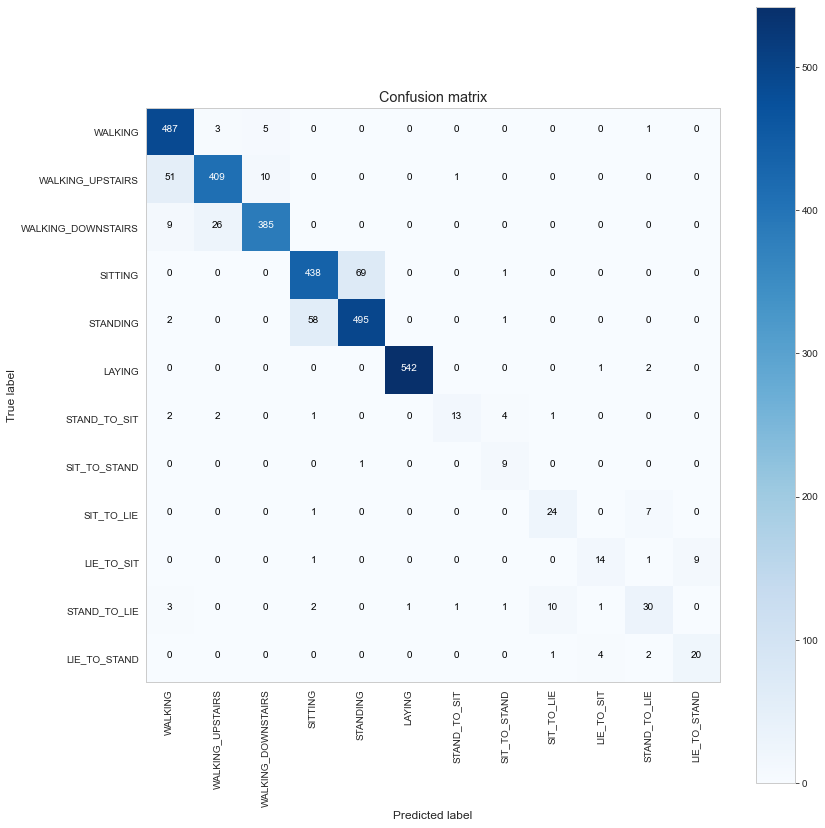

In [24]:
plt.figure(figsize=(12,12))
plot_confusion_matrix(cmt, labels)

In [25]:
print("Classification Report for MLP :")
print(classification_report(y_test, y_preds))

Classification Report for MLP :
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       496
           1       0.93      0.87      0.90       471
           2       0.96      0.92      0.94       420
           3       0.87      0.86      0.87       508
           4       0.88      0.89      0.88       556
           5       1.00      0.99      1.00       545
           6       0.87      0.57      0.68        23
           7       0.56      0.90      0.69        10
           8       0.67      0.75      0.71        32
           9       0.70      0.56      0.62        25
          10       0.70      0.61      0.65        49
          11       0.69      0.74      0.71        27

    accuracy                           0.91      3162
   macro avg       0.81      0.80      0.80      3162
weighted avg       0.91      0.91      0.91      3162



In [26]:
# model weights 
with torch.no_grad():
    mlp_params = {}
    for name, param in mlp.named_parameters():
#         print(name,param)
        mlp_params[name] = param.numpy().copy().tolist()
print(mlp_params.keys())
for key in mlp_params.keys(): 
    print(f"{key} : {len(mlp_params[key])} neurons in {key} layer")
    print(f" number of connections  : {len(mlp_params[key])} * {np.asarray(mlp_params[key][len(mlp_params[key]) -1]).size} = {len(mlp_params[key]) * np.asarray(mlp_params[key][len(mlp_params[key]) -1]).size } ")
 

dict_keys(['fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'out.weight', 'out.bias'])
fc1.weight : 80 neurons in fc1.weight layer
 number of connections  : 80 * 136 = 10880 
fc1.bias : 80 neurons in fc1.bias layer
 number of connections  : 80 * 1 = 80 
fc2.weight : 40 neurons in fc2.weight layer
 number of connections  : 40 * 80 = 3200 
fc2.bias : 40 neurons in fc2.bias layer
 number of connections  : 40 * 1 = 40 
out.weight : 12 neurons in out.weight layer
 number of connections  : 12 * 40 = 480 
out.bias : 12 neurons in out.bias layer
 number of connections  : 12 * 1 = 12 


### Save MLP model 

In [27]:
torch.save(mlp.state_dict(), 'MLPW7.pt')

### Load MLP model and run on test set  

In [28]:
loaded_model = Model(in_features=len(X_important_test[0]),h1=80, h2=40)
loaded_model.load_state_dict(torch.load('MLPW7.pt'))
loaded_model.eval()

Model(
  (fc1): Linear(in_features=136, out_features=80, bias=True)
  (fc2): Linear(in_features=80, out_features=40, bias=True)
  (out): Linear(in_features=40, out_features=12, bias=True)
)

In [29]:
with torch.no_grad():
    y_val = loaded_model.forward(X_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

1.51632404


### Applying model on a random sample in the test dataset

In [30]:
random.seed(22)
random_int = random.randint(0, len(X_important_test))
random_input = torch.FloatTensor(X_important_test[random_int])
random_input

tensor([-0.9898, -0.9899, -0.7945, -0.9999, -0.6993,  0.0367, -0.4355, -0.4319,
         0.9593,  0.2223, -0.9844, -0.9854, -0.4919,  0.9092,  0.2206, -0.3906,
         0.9658,  0.2201, -0.4497, -0.9981,  0.8420, -0.9073, -0.5317, -0.4323,
        -0.9366,  0.9386, -0.9406,  0.9427, -0.8492,  0.8599, -0.8710,  0.8818,
        -0.5186,  0.5171, -0.5155,  0.5129, -0.2644, -0.9931, -0.9931, -0.9844,
        -0.9930, -0.9937, -0.9999, -0.9915, -0.9829, -0.7378, -0.9747, -0.9754,
        -0.9719, -0.8905,  0.8516, -0.9808, -0.9712,  0.0870, -0.1575, -0.9916,
        -0.9959, -0.9922, -0.9961, -0.9951, -0.9925, -0.9954, -0.9964, -0.7931,
        -0.9874, -0.9894, -0.9915, -0.9830,  0.0033,  0.0151, -0.9894, -0.9915,
        -0.9830, -0.9874,  0.0033,  0.0151, -0.9941, -0.9941, -0.9999, -0.9951,
        -0.9951, -0.9951, -0.6766, -0.9926, -0.9882, -0.9864, -0.9907, -0.9999,
        -0.0713, -0.9999, -0.9999, -0.9999, -0.9999, -0.9936, -0.9931, -0.9872,
        -0.9909, -0.9939, -0.9956, -0.99

In [31]:
with torch.no_grad():
    print(loaded_model(random_input))
    print()
    print(loaded_model(random_input).max())
    print(loaded_model(random_input).argmax().item())
    print(f"Predicted Output: {map_num_to_activity[loaded_model(random_input).argmax().item()]}")
    print(f"Actual Output: {map_num_to_activity[y_test[random_int].item()]}")

tensor([-246.5458, -551.3735, -305.7671,  -38.1000, -146.0035,  219.7245,
        -195.9030, -471.0799,  -85.1350,   -3.7989, -281.5716,   47.2917])

tensor(219.7245)
5
Predicted Output: LAYING
Actual Output: LAYING


In [32]:
with open('mlp.csv', 'w') as csv_file:  
    writer = csv.writer(csv_file)
    for key, value in mlp_params.items():
       writer.writerow([key, value])